# Naive predictions

Two "predictions" which are very simple.  Surely any reasonable algorithm should be able to out-perform these.  These are not taken directly from the literature, but are "obvious" once you've spent some time with the ideas.

# Naive ("counting grid") algorithm

This is a grid based algorithm.  A grid is laid down on the study region.  We expect that small (50m or less) will perform badly, compared to larger grid sizes.

### Aim of the algorithm

We look at all data before the current time (or perhaps a "sliding window" of the last $n$ months before the current time).  For each grid cell independently, we count the number of events which have occurred in that cell.  This gives the (non-normalised) risk in that cell.

Notice then that there is no direct consideration of time (unless a sliding window is used).  There is no consideration of space, so this algorithm will suffer from the [MAUP](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem) as well as taking no account of likely movement of offenders.

### Prediction

As usual, we can look at the top 1%, 5%, 10% of cells by risk, and so forth.

### Naive KDE

This algorithm is in some sense the most naive answer to the problem that the "counting grid" algorithm suffers from.  The output prediction is in the form of a grid, but this is computed only at the very end, so really the algorith is "continuous".

We take an out the box [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) algorithm, feed in the spatial locations of past crime events (so again, we use all crimes before the current time, and ignore timestamps) and then sample the resulting kernel to a grid.

A KDE is an estimate of a probability density of the form
\[ f(x) = \frac{1}{n} \sum_{i=1}^n K(x - x_i) \]
where $(x_i)$ are the (two dimensional vector) locations of the events.  Here $K$ is the kernel, which is generality can be any two-dimensional function which is positive, and has $\int_{\mathbb R^2} K = 1$.

We use the `scipy` Gaussian KDE.  This first computes the [sample covariance](https://en.wikipedia.org/wiki/Sample_mean_and_covariance) of the input data, and then transforms the data using this to have unit covariance.  Then a "plug in bandwidth rule" is used to choose a value of $h>0$.  Finally $K$ is equal to
\[ K(x) = \frac{1}{2\pi h^2} \exp(- \|x\|^2 / 2h^2). \]
For more details, see the `kernel_estimation.ipynb` notebook under `notebooks`.

A more sophisticated KDE would take account of edge effects (we typically only look at a finite area, while the KDE $f$ will have infinite support, so "predicting" some events outside of the study area).

This tends to give a very (over) smoothly varying kernel.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp
import open_cp.naive as naive

In [2]:
# Generate some random data
import datetime
size = 30
times = [datetime.datetime(2017,3,10) + datetime.timedelta(days=np.random.randint(0,10)) for _ in range(size)]
times.sort()
xc = np.random.random(size=size) * 500
yc = np.random.random(size=size) * 500
points = open_cp.TimedPoints.from_coords(times, xc, yc)

In [3]:
region = open_cp.RectangularRegion(0,500, 0,500)
predictor = naive.CountingGridKernel(50, region=region)
predictor.data = points
prediction = predictor.predict()
prediction

GridPredictionArray(offset=(0,0), size=50x50, risk intensity size=10x10)

The following is the "counting grid" predictor.  Grid cells which contain 2 past events are ranked higher in risk than those which contain only 1 past event.

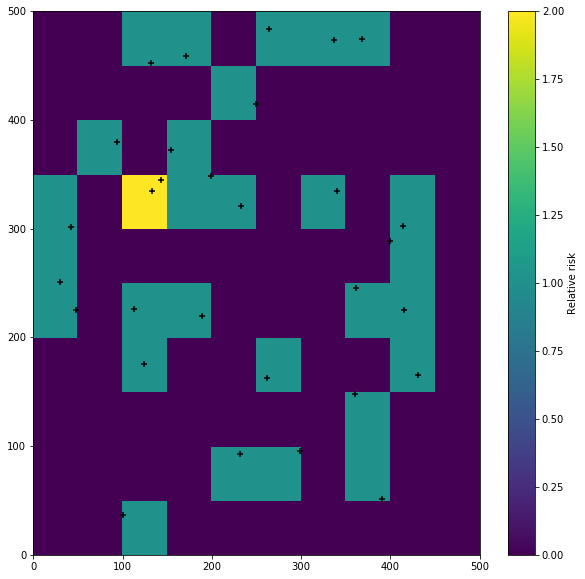

In [4]:
fig, ax = plt.subplots(figsize=(10,10))

m = ax.pcolor(*prediction.mesh_data(), prediction.intensity_matrix)
ax.scatter(points.xcoords, points.ycoords, marker="+", color="black")
ax.set(xlim=[0, 500], ylim=[0, 500])
cb = plt.colorbar(m, ax=ax)
cb.set_label("Relative risk")
None

We now use the `scipy` Gaussian KDE.  We produce a "continuous" prediction, and then sample to a grid of the same size and location as that used before.  Notice that the result is a lot "smoother".

In [5]:
predictor = naive.ScipyKDE()
predictor.data = points
prediction = predictor.predict()
prediction

In [6]:
gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 50)
gridpred

GridPredictionArray(offset=(0,0), size=50x50, risk intensity size=10x10)

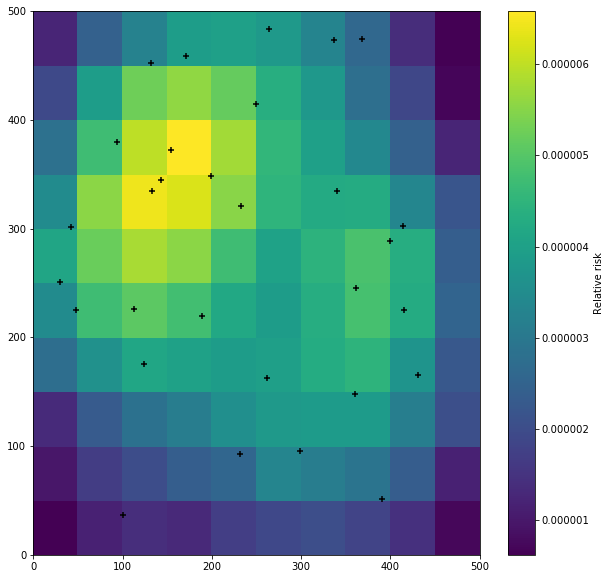

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

m = ax.pcolor(*gridpred.mesh_data(), gridpred.intensity_matrix)
ax.scatter(points.xcoords, points.ycoords, marker="+", color="black")
ax.set(xlim=[0, 500], ylim=[0, 500])
cb = plt.colorbar(m, ax=ax)
cb.set_label("Relative risk")
None